Notebook for generating training/validation data of nonlinear
subthreshold responses to electric current stimuli into biological neuron models
using the Hodkin-Huxley formalism. 

The (synaptic) input currents are modeled
using an Ornstein-Uhlenbeck process (https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process). 

The file output data generated by this 
notebook is used by the HodkinHuxleyConvNet.ipynb notebook.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nest
import h5py

In [3]:
# fix seed
np.random.seed(1234)

In [4]:
# simulation parameters
n_samples = 10000 # number of samples
dt = 0.1         # ms, simulation time res
tstop = 1000     # ms, last timestep of simulation

model='hh_psc_alpha' # neuron model name in NEST

In [5]:
# global parameters for OU process
theta = 0.01
mu = 0.
sigma = 25.
x0 = 0.
dt_OU = 1.

In [6]:
def OUprocess(theta=0.05, mu=10., sigma=1., x0=10.,dt=1., tstop=10000.):
    '''
    Ornstein-Uhlenbeck process from time dt to time tstop

    Parameters
    ----------
    theta : float
        inverse relaxation time constant
    mu : float
        mean
    sigma : float
        standard deviation for process
    x0 : float
        initial value at t = dt
    dt : float
        time resolution (ms)
    tstop : float
        last time point for OU process outpu (ms)

    Returns
    -------
    t : ndarray
        time points for output process (ms)
    x : ndarray

    '''
    t = np.linspace(dt, tstop, int(tstop / dt))

    x = np.zeros_like(t)
    x[0] = x0

    for i in range(1, t.size):
        x[i] = x[i-1] + theta*(mu - x[i-1])*dt + sigma*np.sqrt(dt)*np.random.randn()

    return t, x

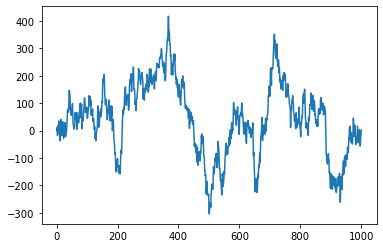

In [7]:
# test plot output of OU process
amplitude_times, amplitude_values = OUprocess(theta=theta, mu=mu, sigma=sigma, x0=x0, dt=dt_OU, tstop=tstop)
plt.figure()
plt.plot(amplitude_times, amplitude_values)

In [8]:
def get_voltage(amplitude_times, amplitude_values, dt=0.1, dt_OU=1., model='hh_psc_alpha'):
    '''
    Predict membrane voltage of neuron for input defined by 
    current input amplitude_values at time amplitude_times
    
    Arguments:
    ----------
    amplitude_times: ndarray
    amplitude_values: ndarray
    dt: float
    dt_OU: float
    model: str
    
    Returns:
    --------
    V_m: ndarray
    '''
    nest.ResetKernel()
    nest.SetKernelStatus(dict(resolution=dt))
    
    # create neuron
    neurons = nest.Create(model)

    # input current device
    ng = nest.Create('step_current_generator')
    nest.SetStatus(ng, dict(amplitude_times=amplitude_times, 
                            amplitude_values=amplitude_values))

    vm = nest.Create('voltmeter')
    nest.SetStatus(vm, dict(interval=dt_OU))

    nest.Connect(ng, neurons)
    nest.Connect(vm, neurons)

    nest.Simulate(tstop+dt)

    events = nest.GetStatus(vm, 'events')[0]
    return events['V_m']

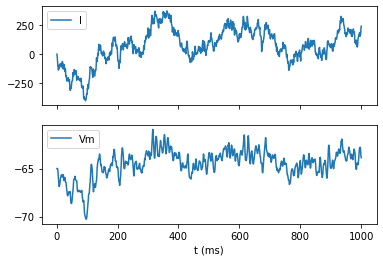

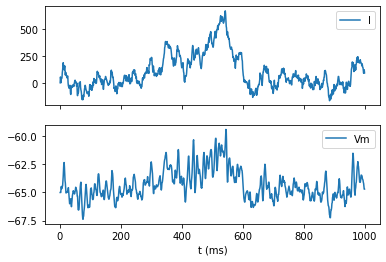

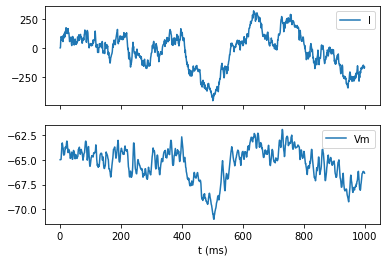

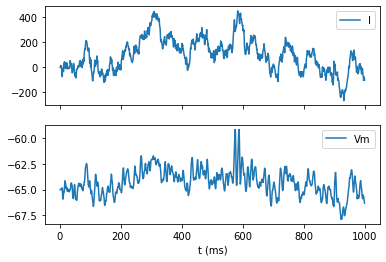

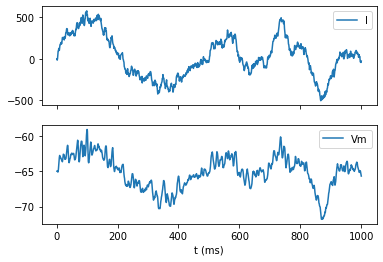

In [9]:
# test get_voltage function
for i in range(5):
    amplitude_times, amplitude_values = OUprocess(theta=theta, mu=mu, sigma=sigma, x0=x0, dt=dt_OU, tstop=tstop)
    V_m = get_voltage(amplitude_times, amplitude_values, dt=0.1, dt_OU=1., model='hh_psc_alpha')
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(amplitude_times, amplitude_values, label='I')
    axes[1].plot(amplitude_times, V_m, label='Vm')
    for ax in axes:
        ax.legend()
    axes[1].set_xlabel('t (ms)')

In [10]:
# set up datas
X = np.empty((n_samples, int(tstop//dt_OU), 1))
Y = np.empty_like(X)

In [11]:
# generate data
for i in range(n_samples):
    amplitude_times, amplitude_values = OUprocess(theta=theta, mu=mu, sigma=sigma, x0=x0, dt=dt_OU, tstop=tstop)
    X[i, :, 0] = amplitude_values
    Y[i, :, 0] = get_voltage(dt=dt, 
                             dt_OU=dt_OU, 
                             model=model, 
                             amplitude_times=amplitude_times, 
                             amplitude_values=amplitude_values)

In [12]:
# save data
f = h5py.File('HH_data.h5', 'w')
f['X'] = X
f['Y'] = Y
f.close()

In [13]:
# create another validation set with longer durations
tstop = 10000.
n_samples = 10

# datas
X_val = np.empty((n_samples, int(tstop//dt_OU), 1))
Y_val = np.empty_like(X_val)

# generate data
for i in range(n_samples):
    amplitude_times, amplitude_values = OUprocess(theta=theta, mu=mu, sigma=sigma, x0=x0, dt=dt_OU, tstop=tstop)
    X_val[i, :, 0] = amplitude_values
    Y_val[i, :, 0] = get_voltage(dt=dt, 
                             dt_OU=dt_OU, 
                             model=model, 
                             amplitude_times=amplitude_times, 
                             amplitude_values=amplitude_values)
# save data
f = h5py.File('HH_data.h5', 'a')
f['X_val'] = X_val
f['Y_val'] = Y_val
f.close()